# Predicting Dengue Spread

## Project Overview

In this notebook we examine feature imacting the occuance of Dengue Fever and employ several machine learning model to predict its spread. Dengue surveillance data is provided by the U.S. Centers for Disease Control and prevention, as well as the Department of Defense's Naval Medical Research Unit 6 and the Armed Forces Health Surveillance Center, in collaboration with the Peruvian government and U.S. universities. Environmental and climate data is provided by the National Oceanic and Atmospheric Administration (NOAA), an agency of the U.S. Department of Commerce.
The project is part of the "Predict the Next Pandemic Initiative"

The data set is hosted at Driven Data, which provides datasets that explore social and humanitarian issues. They also host machine learning competions, similar to Kaggle, but the overarching goal of all competitions is to provides some sort of humaniarial benefit. It's machine learning with a heart!

Here is a link to Driven Data: https://www.drivendata.org/ 
More information on the Dengue issue can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/81/

If you are unfamiliar with Dengue Fever (it is uncommon in the US), is a mosquito-borne tropical disease common in more than 110 countries, mainly in Asia and South America. Each year between 50 and 528 million people are infected and approximately 10,000 to 20,000 die.
The Wikipedia page is a good resouce: https://en.wikipedia.org/wiki/Dengue_fever

And here is some info on the life cycle of the mosquito: https://www.cdc.gov/dengue/resources/factSheets/MosquitoLifecycleFINAL.pdf

### Here are the starting features

City and date indicators
* city – City abbreviations: sj for San Juan and iq for Iquitos
* week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements
* station_max_temp_c – Maximum temperature
* station_min_temp_c – Minimum temperature
* station_avg_temp_c – Average temperature
* station_precip_mm – Total precipitation
* station_diur_temp_rng_c – Diurnal temperature range

PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
* precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
* reanalysis_sat_precip_amt_mm – Total precipitation
* reanalysis_dew_point_temp_k – Mean dew point temperature
* reanalysis_air_temp_k – Mean air temperature
* reanalysis_relative_humidity_percent – Mean relative humidity
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity
* reanalysis_precip_amt_kg_per_m2 – Total precipitation
* reanalysis_max_air_temp_k – Maximum air temperature
* reanalysis_min_air_temp_k – Minimum air temperature
* reanalysis_avg_temp_k – Average air temperature
* reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
* ndvi_se – Pixel southeast of city centroid
* ndvi_sw – Pixel southwest of city centroid
* ndvi_ne – Pixel northeast of city centroid
* ndvi_nw – Pixel northwest of city centroid

### Target Variable

The target we are investigating is "totol cases", which is a specifies for each city, year, and weekofyear. 

#### Lets begin:

In [96]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
data_path = []
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_path.append(os.path.join(dirname, filename))
        


.\dengue_analyze.py
.\dengue_features_train.csv
.\dengue_labels_train.csv
.\dengue_predict.ipynb
.\Untitled.ipynb
.\Wells-Gray_Res_DA_10172019.docx
.\.ipynb_checkpoints\dengue_predict-checkpoint.ipynb
.\.ipynb_checkpoints\Untitled-checkpoint.ipynb


In [98]:
# Load the data
df_feat = pd.read_csv(data_path[1])
df_targ = pd.read_csv(data_path[2])
#print(df_targ.columns)

## Data Exploration

In [99]:
# df_o will be our original dataframe, which will be left untouched
df_o=pd.concat([df_feat,df_targ.total_cases],axis=1)
df_o.sample(5)
#df_o.columns

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1166,iq,2004,49,2004-12-02,0.201943,0.159367,0.159043,0.241086,53.01,299.177143,...,87.130000,53.01,18.110000,10.957143,27.900000,11.000000,34.1,22.4,64.0,83
1298,iq,2007,25,2007-06-18,0.166700,0.120786,0.172971,0.165900,78.83,296.118571,...,94.065714,78.83,16.422857,6.885714,25.966667,7.600000,32.0,21.2,126.0,1
885,sj,2007,19,2007-05-07,-0.062050,-0.027650,0.142929,0.171843,9.83,299.467143,...,79.194286,9.83,16.947143,2.771429,27.328571,6.771429,31.7,23.3,20.5,8
701,sj,2003,43,2003-10-22,-0.041600,0.055300,0.169929,0.128171,20.44,301.090000,...,77.531429,20.44,18.301429,2.857143,28.028571,7.000000,32.8,23.9,10.9,39
1004,iq,2001,43,2001-10-22,0.124483,0.239267,0.184500,0.205571,77.15,298.584286,...,90.265714,77.15,18.267143,9.857143,28.066667,11.966667,35.0,21.0,89.1,0


In [100]:
# Data are mostly floats, with a couple ints and a couple objects
print('\n Rows and Columns:')
print(df_o.shape)
print('\n Data Types:')
print(df_o.dtypes)


 Rows and Columns:
(1456, 25)

 Data Types:
city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c      

Here we define a function for displaying a correlation matrix for different features.

In [101]:
# Create working copy of the data for cleaning (df_o to remain unchanged)
df = df_o.copy()
df.isnull().sum().sort_values(ascending=False)
#len(df)

ndvi_ne                                  194
ndvi_nw                                   52
station_diur_temp_rng_c                   43
station_avg_temp_c                        43
ndvi_se                                   22
ndvi_sw                                   22
station_precip_mm                         22
station_max_temp_c                        20
station_min_temp_c                        14
reanalysis_sat_precip_amt_mm              13
precipitation_amt_mm                      13
reanalysis_max_air_temp_k                 10
reanalysis_avg_temp_k                     10
reanalysis_air_temp_k                     10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
weekofyear                                 0
year                                       0
total_case

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E38EA20B70>,
      dtype=object)

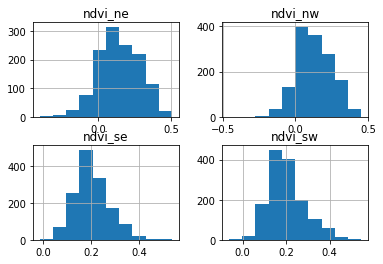

In [102]:
df[["ndvi_se","ndvi_sw","ndvi_ne","ndvi_nw"]].hist()

We could drop ndvi_ne as it is highly correlated with ndvi_nw, however currently we will try imputing with the mean of the other 3 ndvi variables. The 52 cases where ndvi_nw is missing, we will replace with the mean of ndvi_se and ndvi_sw. Where ndvi_se and ndvi_s are missing, we will impute with the mean. 

In [103]:
df.ndvi_se.fillna(df.ndvi_se.mean(),inplace=True)
df.ndvi_sw.fillna(df.ndvi_sw.mean(),inplace=True)
df.ndvi_nw.fillna((df.ndvi_sw + df.ndvi_se)/2,inplace=True)
df.ndvi_ne.fillna((df.ndvi_sw + df.ndvi_se + df.ndvi_nw)/3,inplace=True)

We will impute other rows with missing values with the mean of the respective column.

In [104]:
df.fillna(df.mean(),inplace=True)

We will eventually going to drop year from the subesquent analysis, due to potential data leakage, but we will engineer some features using it later on.  

In [105]:
#df.drop("year", axis=1,inplace=True)
#df.columns

## Categorial Features

In [106]:
cat_features = df.loc[:,(df.dtypes=='object')]
cat_features.columns

Index(['city', 'week_start_date'], dtype='object')

For now we will drop week_start_date. The day of the month likely has no bearing on dengue cases, week is already represented in its own feature/column, and year is being dropped due to leakage. 

In [107]:
df.drop('week_start_date', axis=1,inplace=True)
#df.columns

Lets look at the city attribute.

In [108]:
df.city.unique()

array(['sj', 'iq'], dtype=object)

Only two cities. Will do categorical encoding (though one-hot could also be used)

In [109]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["sj","iq"])
#le.classes_
df.city=le.transform(df.city)
df.head()


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [110]:
df.dtypes

city                                       int32
year                                       int64
weekofyear                                 int64
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c  

Text(0,0.5,'count')

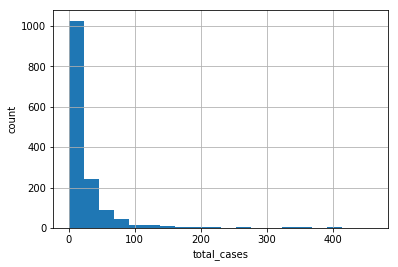

In [111]:
df['total_cases'].hist(bins=20)
plt.xlabel('total_cases')
plt.ylabel('count')

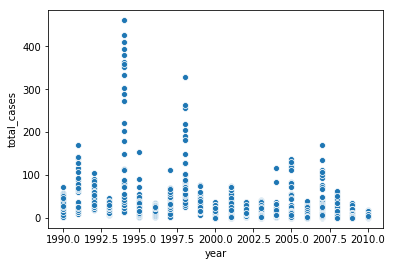

In [112]:
import seaborn as sn

sn.scatterplot(x="year",y="total_cases",data=df)

In [113]:
def plot_corr_matrix(df, subset=[], details="All Features"):

    if len(subset)>0:
        df = df[subset]
        
    corr = df.corr()
    #cmap = sn.diverging_palette(255, 133, l=60, n=7, center="dark")
    
    # The values number here ar just for "nice" scaling
    xx=(df.shape[1]/3,(df.shape[1]/3)*.85 )
    fig=plt.figure(figsize=xx)
    ax = sn.heatmap(corr,cmap='RdBu_r',vmin=-1,vmax=1)

    ax.set_title("Correlation for "+details)

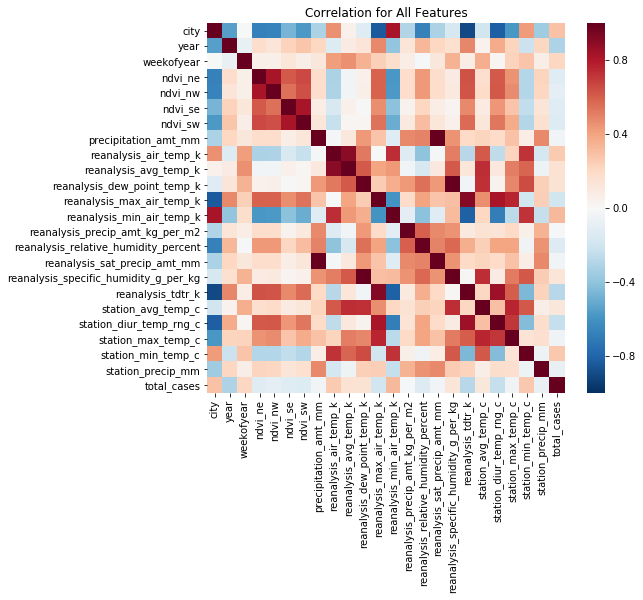

In [114]:
# Let's start by looking at all features; target variable is in the last row/column
plot_corr_matrix(df=df, subset=[], details="All Features") 

The bottom row and right-most column on the above correlation matrix show how each feature correlates with total cases. We observe many features that are weekly-to-moderately correlated with total_case(0.2-0.4), but none that are ***strongly*** correlated.

Text(0.5,1,'Feature Correlation (with Target)')

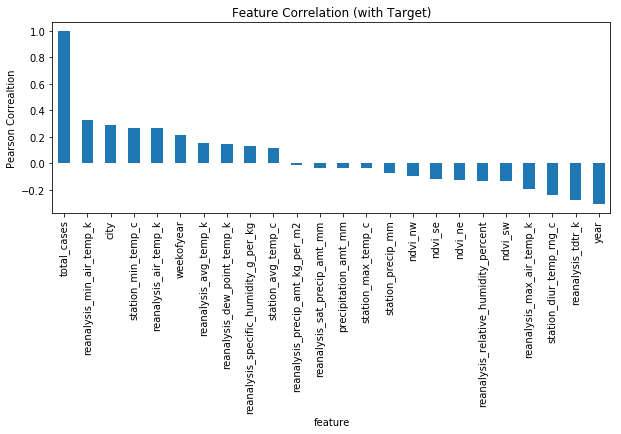

In [115]:
plt.figure(figsize=(10,3.5))
#%matplotlib inline
df.corr().iloc[-1].sort_values(ascending=False).plot(kind="bar")
#plt.show()
plt.xlabel('feature')
plt.ylabel('Pearson Correaltion')
plt.title('Feature Correlation (with Target)')

In [147]:
def move_target_to_end(df,target_label):
        cols = df.columns.tolist()
        #print(cols[23])
        p = cols.index(target_label)
        print(p)
        cols_new=cols[0:p]
        cols_new = cols_new + cols[p+1:]
        cols_new.append(cols[p])
        #print(cols_new)
        df=df[cols_new]
        return df

In [166]:
exclude_labels=['year']
def select_top_features(df,n_features=10, target_label='total_cases',exclude_labels=exclude_labels):
    """ Select the n featrues most highly correlation with the specified 
    target aviables. . NOTE: should only run this with df that has the target 
    still embedded; will return erroneour result if used e.g. with x"""
    
    df=move_target_to_end(df,target_label)
    
    _=abs(df.corr()).iloc[-1].sort_values(ascending=False)
    #print(exclude_labels)
    high_corr_feat = list(_.index[1:n_features])
    for li in range(len(exclude_labels)):
        high_corr_feat.remove(exclude_labels[li]) 
    #print(high_corr_feat)
    return high_corr_feat

In [167]:
df=move_target_to_end(df,'total_cases')

23


In [168]:
high_corr_feat = select_top_features(df,n_features=10)
print(high_corr_feat)

23
['reanalysis_min_air_temp_k', 'city', 'reanalysis_tdtr_k', 'station_min_temp_c', 'reanalysis_air_temp_k', 'station_diur_temp_rng_c', 'weekofyear', 'reanalysis_max_air_temp_k']


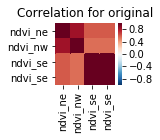

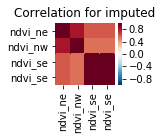

In [169]:
# Check the correlation matrices for the ndvi features, before and after imputation
plot_corr_matrix(df=df_o, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="original") 
plot_corr_matrix(df=df, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="imputed") 

No lets look how the data are distributed.

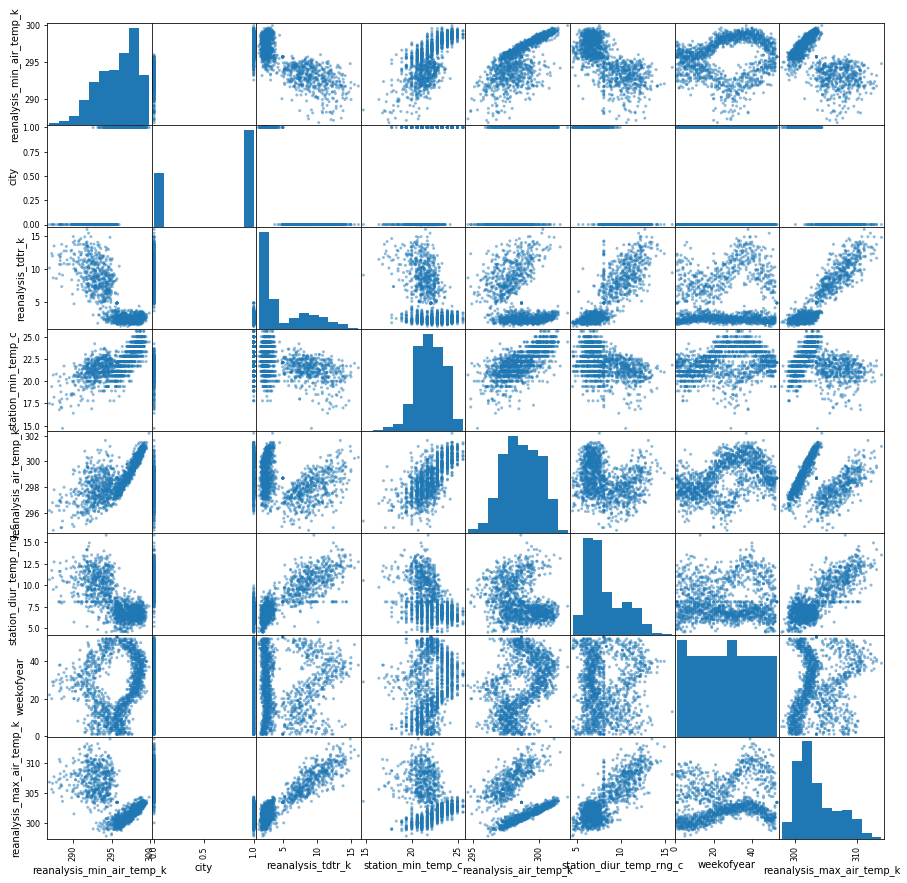

In [170]:
_=pd.plotting.scatter_matrix(df[high_corr_feat], figsize=(15,15))

Look at the year row, it looks like something strang is happening reguarding data before and after ~2000 for several of the attributes: **reanalysis_min_air_temp_k, reanalysis_tdtr_k, station_diur_temp_rng_c, and reanalysis_max_air_temp_k***. For all of these feature, values are much more dispersed PRIOR to 2000. Let's take for example: reanalysis_min_air_temp_k.


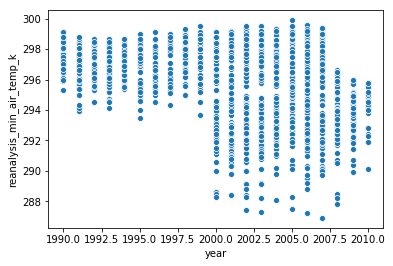

In [171]:
sn.scatterplot(df["year"],df["reanalysis_min_air_temp_k"])

It seems unlikely that after 2000, minumum air temps dropped that dramatically and consistently. And it's the same for most other realated variable. 

In [172]:
import math
df2=df.copy()
df2['log_total_cases']=np.log(df2['total_cases']+.001)
df2.sample(10)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,log_total_cases
1399,0,2009,22,0.238343,0.197317,0.165500,0.190143,40.040000,296.704286,297.521429,...,40.040000,17.830000,5.614286,27.600000,10.266667,34.400000,21.00000,19.30000,2,0.693647
1357,0,2008,32,0.200200,0.251386,0.211343,0.199729,32.450000,297.310000,298.571429,...,32.450000,17.057143,9.742857,27.400000,12.100000,34.200000,18.50000,18.10000,2,0.693647
374,1,1997,28,0.088300,0.074833,0.135457,0.111857,5.870000,300.488571,300.642857,...,5.870000,17.845714,2.428571,29.014286,7.542857,33.900000,23.90000,8.70000,9,2.197336
202,1,1994,11,0.146800,-0.048150,0.194683,0.140550,0.000000,297.501429,297.671429,...,0.000000,14.334286,2.571429,25.842857,7.957143,31.100000,21.10000,16.80000,24,3.178095
139,1,1993,53,0.203044,0.203044,0.203783,0.202305,45.760388,298.701852,299.225578,...,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.10215,39.32636,30,3.401231
7,1,1990,25,0.072500,0.072500,0.151471,0.133029,151.120000,299.591429,299.528571,...,151.120000,17.977143,1.571429,28.371429,7.685714,33.900000,22.80000,21.10000,5,1.609638
443,1,1998,45,0.129593,-0.002250,0.221229,0.169800,121.650000,299.652857,299.692857,...,121.650000,18.484286,1.785714,27.428571,6.457143,31.100000,23.30000,81.50000,55,4.007351
838,1,2006,23,0.014400,0.014400,0.104580,0.133829,19.930000,300.768571,300.907143,...,19.930000,17.464286,3.042857,28.914286,8.342857,34.400000,24.40000,1.30000,5,1.609638
284,1,1995,41,0.040825,0.096600,0.131600,0.137543,45.630000,299.540000,299.564286,...,45.630000,18.138571,1.814286,28.385714,6.928571,32.200000,24.40000,19.10000,30,3.401231
436,1,1998,38,0.112354,0.040100,0.155483,0.141480,35.030000,300.587143,300.607143,...,35.030000,18.847143,2.185714,28.728571,6.985714,34.400000,24.40000,39.70000,54,3.989003


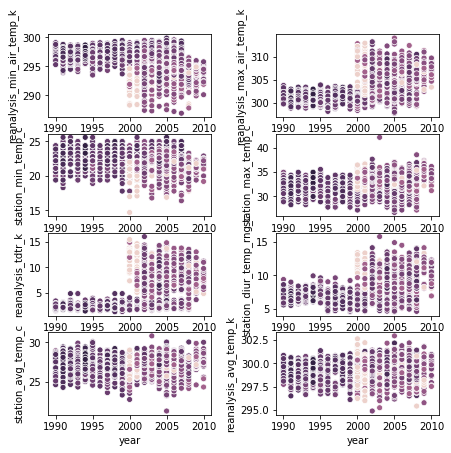

In [173]:
fig,ax = plt.subplots(4,2, figsize=(7,7))
#sca=axes[0,0]
plt.subplots_adjust(wspace=.4)
sn.scatterplot(x="year",y="reanalysis_min_air_temp_k",data=df2, ax=ax[0,0],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="reanalysis_max_air_temp_k",data=df2, ax=ax[0,1],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="station_min_temp_c",data=df2, ax=ax[1,0],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="station_max_temp_c",data=df2, ax=ax[1,1],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="reanalysis_tdtr_k",data=df2, ax=ax[2,0],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="station_diur_temp_rng_c",data=df2, ax=ax[2,1],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="station_avg_temp_c",data=df2, ax=ax[3,0],hue="log_total_cases",legend=False)
sn.scatterplot(x="year",y="reanalysis_avg_temp_k",data=df2, ax=ax[3,1],hue="log_total_cases",legend=False)


Across the board, temperture ranges were smaller before 2000. But the effect is less noticible in the "station" measurents. ~10-deg range disparity for "realanalysi"; only ~5-deg disparity for station. 

This stongly indicates some sort of measurement bias/error (perhaps new equipement was established in 200). This needs to be accounted for with some sort o correction. 

A simply approach would be an indicator variable for before/after 2000. See this below in Feature Engineering section. 



### Prepare the Data (split into x and y)

In [174]:
def split_xy(df,drop_atts):
    X = df.copy()
    X.drop(drop_atts, axis=1, inplace=True)
    Y = df.total_cases
    return X,Y

In [175]:
x,y = split_xy(df,drop_atts =["total_cases","year"])
x.columns

Index(['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [176]:
#numberical featuers (all feature should now be numerical)
#num_features = x.loc[:,(df.dtypes=='int64')|(df.dtypes=='float64')|(df.dtypes=='int32')]
#num_features.columns
#num_features.dtypes

In [177]:
df.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

## Baseline Linear Regression Model

Now that we've done some basic data exploration and cleaning, let's do a preliminarly linear regression before any feature engineering. This will serve as starting point. We will just take numerical features--we will explore categorical encoding a bit later on. 

First let's funcationalize our linear regression model.


In [178]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [179]:
def lin_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = LinearRegression()
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='neg_mean_squared_error')
    print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [180]:
from sklearn.tree import DecisionTreeRegressor

def dtree_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = DecisionTreeRegressor(random_state=3)
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='neg_mean_squared_error')
    print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [181]:
from sklearn.ensemble import RandomForestRegressor

def randfor_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = RandomForestRegressor(random_state=3, n_estimators=100)
    if do_scale:
        regressor = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='neg_mean_squared_error')
    print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [182]:
# Baseline Linear regression, no bell/whistles, to get a starting point
# all numerical features
lin_reg(x,y)

RMSE: -1877.05 (+/- 4281.88)
[[ 2.  0.]
 [ 9. -9.]
 [20.  6.]
 [22. 35.]
 [ 4.  0.]
 [17. 34.]
 [ 5. 21.]
 [ 0.  7.]
 [ 3. 35.]
 [32. 19.]]


In [183]:
# Baseline scores for decision tree
dtree_reg(x,y)

RMSE: -2708.19 (+/- 4979.79)
[[  4.   2.]
 [ 40. 112.]
 [  8.  15.]
 [141.  23.]
 [ 48.  30.]
 [ 17.  13.]
 [  7.   4.]
 [  0.   2.]
 [  7.   9.]
 [  0.   8.]]


In [184]:
# Baseline scores for decision tree
randfor_reg(x,y)

RMSE: -1972.60 (+/- 4053.69)
[[21. 19.]
 [ 0.  3.]
 [37. 48.]
 [40. 67.]
 [19. 55.]
 [78. 27.]
 [ 0.  2.]
 [ 0.  3.]
 [17. 17.]
 [22. 14.]]


In [185]:
high_corr_feat = select_top_features(df,n_features=6)
print(high_corr_feat)

23
['reanalysis_min_air_temp_k', 'city', 'reanalysis_tdtr_k', 'station_min_temp_c']


In [186]:
high_corr_feat

['reanalysis_min_air_temp_k',
 'city',
 'reanalysis_tdtr_k',
 'station_min_temp_c']

In [187]:
# Baseline Linear regression, but with a subset of features
lin_reg(x,y,features=high_corr_feat)

RMSE: -1822.42 (+/- 4314.75)
[[  3.  31.]
 [ 19.  29.]
 [ 19.  21.]
 [ 31.  25.]
 [  0.  -4.]
 [  0.   2.]
 [  0.   5.]
 [131.  44.]
 [129.  33.]
 [ 13.  43.]]


Selecting the 10 best features greatly benefits the linear regression model, but has a negative impact on the tree methods, as shown in the outputs of the next two cells.

In [188]:
# Baseline scores for decision tree
dtree_reg(x,y,features=high_corr_feat)

RMSE: -4752.37 (+/- 6663.04)
[[461.   8.]
 [ 27.  29.]
 [ 25.  45.]
 [  5.   8.]
 [ 23.   7.]
 [ 40.  12.]
 [  8.   3.]
 [ 80.  89.]
 [ 13.   5.]
 [ 68. 410.]]


In [189]:
# Baseline scores for decision tree
randfor_reg(x,y,features=high_corr_feat)

RMSE: -2524.67 (+/- 4410.41)
[[27. 41.]
 [16. 20.]
 [ 3.  2.]
 [50. 16.]
 [ 5. 15.]
 [53. 53.]
 [38. 54.]
 [41. 24.]
 [26. 23.]
 [ 9. 16.]]


So, we're clearly starting from a place of poor prediction. Plenty of room for improvement!

The plan going forward is to:
* Perform categorical encoding for our categorical feature
* Engineer some features
* Explore some other regression models and choose 2-3 to fine-tune
* Optimize our chosen models using regularization and gridsearc

## Feature Engineering
 

As metioned earlier, there is somesort of discrepancy between temperture reading before/after the year 2000. So for know we'll create and indicator for that. However, ultimately we should implement a correction, because this feature will not be appropriate for new instances (meaning those that occur in the future--by definition after the year 2000).

In [190]:
def before_2000(year):
    if year < 2000:
        return 0
    else:
        return 1
    
df['before_2000'] = df['year'].apply(before_2000)

In [191]:
df.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'before_2000'],
      dtype='object')

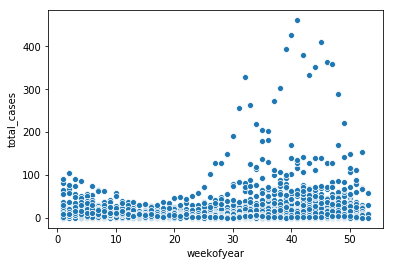

In [192]:
sn.scatterplot(x='weekofyear',y='total_cases',data=df)

In [193]:
def week_season(weekofyear):
    if (weekofyear<=22)&(weekofyear>=10):
        return 0
    elif (weekofyear<10):        
        return 1
    else:
        return 2
    
df['week_season'] = df['weekofyear'].apply(week_season)

In [194]:
df['re_max_over_min'] = df.reanalysis_max_air_temp_k/df.reanalysis_min_air_temp_k

In [195]:
df['station_max_over_min'] = df.station_max_temp_c/df.station_min_temp_c

In [196]:
df.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases', 'before_2000',
       'week_season', 're_max_over_min', 'station_max_over_min'],
      dtype='object')

In [197]:
df.year.min()

1990

In [198]:
df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,before_2000,week_season,re_max_over_min,station_max_over_min
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,25.442857,6.900000,29.4,20.0,16.0,4,0,0,1.013180,1.470000
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,26.714286,6.371429,31.7,22.2,8.6,5,0,0,1.015182,1.427928
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,26.714286,6.485714,32.2,22.8,41.4,4,0,0,1.010764,1.412281
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,27.471429,6.771429,33.3,23.3,4.0,3,0,0,1.014815,1.429185
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,28.942857,9.371429,35.0,23.9,5.8,6,0,0,1.014790,1.464435


In [199]:
def att_prev_week(df, att, new_label,num_weeks=1):
    t = []
    for i in range(len(df)):    
        prev_val = []
        #row = df.iloc[i]
        Year = df.year.iloc[i]
        City = df.city.iloc[i]
        Week = df.weekofyear.iloc[i]
        #print(Year,City,Week)

        if Week<=(1+(num_weeks-1)):
            prev_val = df[att].loc[(df.city==City)&(df.year==Year)&(df.weekofyear==Week-num_weeks)]
        # This else only catches week = 1 if year is not 1990. now previous week in that case
        elif (Week>(1+(num_weeks-1)))&(Year!=df.year.min):
            prev_val = df[att].loc[(df.city==City)&(df.year==Year-1)&(df.weekofyear==(52-(num_weeks-1)))]
        else:
            #
            prev_val = df[att].loc[(df.city==City)&(df.year==Year)&(df.weekofyear)]

        #print(prev_val.values)
        if len(prev_val)==0:
            prev_val = df[att].loc[(df.city==City)&(df.year==Year)&(df.weekofyear)]
        t.append(prev_val.values[0])
    df[new_label] = t
    print(new_label)
    return t

['prev2_week_re_max_temp',
 'city',
 're_max_over_min',
 'reanalysis_tdtr_k',
 'prev_week_re_max_temp',
 'reanalysis_max_air_temp_k',
 'station_diur_temp_rng_c',
 'reanalysis_min_air_temp_k',
 'prev2_week_re_min_temp',
 'station_max_over_min']

In [200]:
select_top_features(df,n_features=10)

23


['before_2000',
 'reanalysis_min_air_temp_k',
 'city',
 're_max_over_min',
 'reanalysis_tdtr_k',
 'station_min_temp_c',
 'reanalysis_air_temp_k',
 'station_max_over_min']

In [201]:
att='station_precip_mm'
_=att_prev_week(df, att,'prev_week_st_precip',num_weeks=1)

att='station_precip_mm'
_=att_prev_week(df, att,'prev2_week_st_precip',num_weeks=2) 

att='station_precip_mm'
_=att_prev_week(df, att,'prev3_week_st_precip',num_weeks=3) 

att='reanalysis_min_air_temp_k'
_=att_prev_week(df, att,'prev_week_re_min_temp',num_weeks=1) 

att='reanalysis_min_air_temp_k'
_=att_prev_week(df, att,'prev2_week_re_min_temp',num_weeks=2) 

att='reanalysis_min_air_temp_k'
_=att_prev_week(df, att,'prev23_week_re_min_temp',num_weeks=3) 

att='reanalysis_max_air_temp_k'
_=att_prev_week(df, att,'prev_week_re_max_temp',num_weeks=1) 

att='reanalysis_max_air_temp_k'
_=att_prev_week(df, att,'prev2_week_re_max_temp',num_weeks=2) 

att='reanalysis_max_air_temp_k'
_=att_prev_week(df, att,'prev3_week_re_max_temp',num_weeks=3) 

att='re_max_over_min'
_=att_prev_week(df, att,'prev_re_max_over_min',num_weeks=1) 

att='re_max_over_min'
_=att_prev_week(df, att,'prev2_re_max_over_min',num_weeks=2) 

att='re_max_over_min'
_=att_prev_week(df, att,'prev3_re_max_over_minp',num_weeks=3) 

att='reanalysis_tdtr_k'
_=att_prev_week(df, att,'prev_reanalysis_tdtr_k',num_weeks=1) 

att='reanalysis_tdtr_k'
_=att_prev_week(df, att,'prev2_reanalysis_tdtr_k',num_weeks=2) 

att='reanalysis_tdtr_k'
_=att_prev_week(df, att,'prev3_reanalysis_tdtr_k',num_weeks=3) 


prev_week_st_precip
prev2_week_st_precip
prev3_week_st_precip
prev_week_re_min_temp
prev2_week_re_min_temp
prev23_week_re_min_temp
prev_week_re_max_temp
prev2_week_re_max_temp
prev3_week_re_max_temp
prev_re_max_over_min
prev2_re_max_over_min
prev3_re_max_over_minp
prev_reanalysis_tdtr_k
prev2_reanalysis_tdtr_k
prev3_reanalysis_tdtr_k


In [202]:
df=move_target_to_end(df,'total_cases')

23


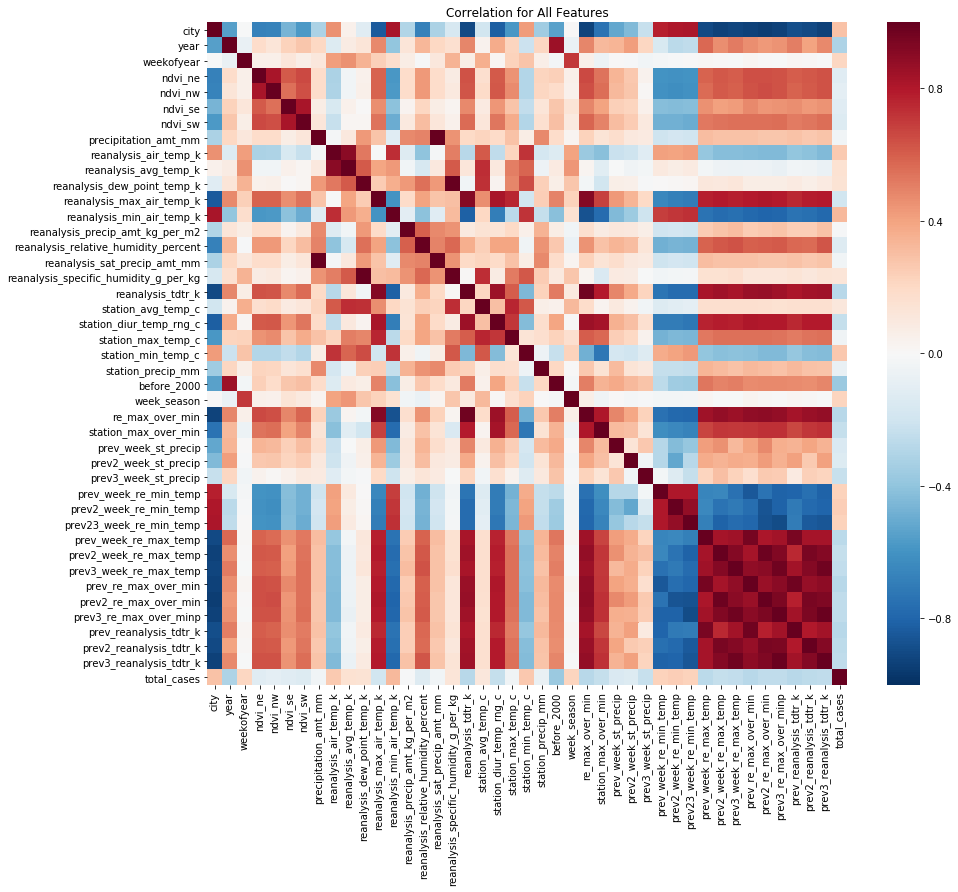

In [203]:
# Let's start by looking at all features; target variable is in the last row/column
plot_corr_matrix(df=df, subset=[], details="All Features") 

Text(0.5,1,'Feature Correlation (with Target)')

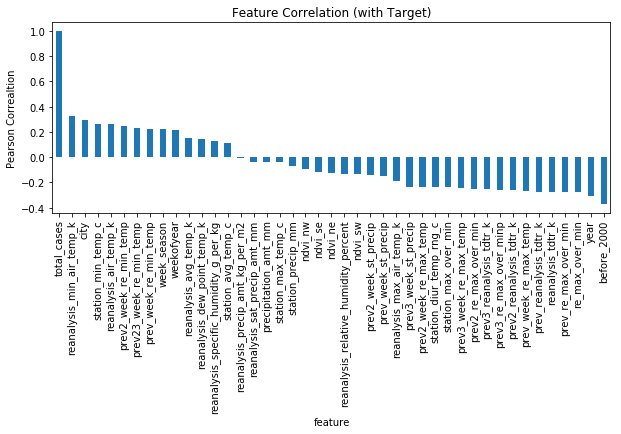

In [204]:
plt.figure(figsize=(10,3.5))
#%matplotlib inline
df.corr().iloc[-1].sort_values(ascending=False).plot(kind="bar")
#plt.show()
plt.xlabel('feature')
plt.ylabel('Pearson Correaltion')
plt.title('Feature Correlation (with Target)')

In [207]:
select_top_features(df,n_features=10)

42


['before_2000',
 'reanalysis_min_air_temp_k',
 'city',
 're_max_over_min',
 'prev_re_max_over_min',
 'reanalysis_tdtr_k',
 'prev_reanalysis_tdtr_k',
 'prev_week_re_max_temp']

In [208]:
x,y = split_xy(df,drop_atts =["total_cases","year"])
x.columns

Index(['city', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'before_2000', 'week_season',
       're_max_over_min', 'station_max_over_min', 'prev_week_st_precip',
       'prev2_week_st_precip', 'prev3_week_st_precip', 'prev_week_re_min_temp',
       'prev2_week_re_min_temp', 'prev23_week_re_min_temp',
       'prev_week_re_max_temp', 'prev2_week_re_max_temp',
       'prev3_week_re_max_temp', 'prev_re_max_over_min',
       'prev2_re_max_over_min', 'prev3_re_max_over_minp',
       'p

In [209]:
top10=select_top_features(df,n_features=10)

42


In [210]:
lin_reg(x,y,features=select_top_features(df,n_features=26))

42
RMSE: -2626.74 (+/- 3545.15)
[[ 5. 19.]
 [10.  2.]
 [24. 48.]
 [ 4. 30.]
 [18. 19.]
 [ 3. 18.]
 [ 0. 11.]
 [10. 15.]
 [ 8. -3.]
 [29. 36.]]


In [211]:
randfor_reg(x,y,features = select_top_features(df,n_features=11))

42
RMSE: -2178.32 (+/- 4191.38)
[[12. 35.]
 [21. 47.]
 [ 6. 19.]
 [ 3. 14.]
 [26. 13.]
 [20. 12.]
 [21. 22.]
 [ 6. 11.]
 [ 0.  9.]
 [ 1.  4.]]


In [212]:
from sklearn.preprocessing import PowerTransformer

def lin_reg_pow(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    """ Linear Regressio with Power Tranformer"""    
    if len(features)>0:
        #print(len(features)>0)
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = LinearRegression()
    if do_scale:
        regressor = Pipeline(steps = [('scaler',PowerTransformer()),('model',model)])
    else:
        regressor = Pipeline(steps = [('model',model)])
        
    regressor.fit(x_train,y_train)
    y_predict = regressor.predict(x_val)
    
    scores = cross_val_score(regressor, x, y, cv=5, scoring='neg_mean_squared_error')
    print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # Display some random validation vs predicted y pairs
    rand_samp = list(np.random.choice(range(len(y_val)),10,replace=False))
    y_top = np.array(y_val.iloc[rand_samp])
    # Rounding the predicted values for display purposes
    yp_top = np.array(y_predict[rand_samp]).round()
    
    Y = np.array([y_top,yp_top]).T
    print(Y)

In [213]:
lin_reg_pow(x,y,features = select_top_features(df,n_features=26))

42


C:\Users\ewell\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\ewell\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * 

RMSE: -1972.69 (+/- 3721.17)
[[ 4. 32.]
 [92. 46.]
 [23. 13.]
 [ 1. -9.]
 [48. 43.]
 [ 1. 21.]
 [ 6. 12.]
 [25. 54.]
 [ 7. 52.]
 [26. 24.]]


C:\Users\ewell\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\ewell\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ewell\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\ewell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * n

One feature to engineer is an obvious one: number of case for the same city in the previous year. While we are at it, we could do it for a range of previous years. Lets limit it at 3.  The year range for this data is 1990-2010. So if we want to do a feature for each of the 3 previous year, problems arrise for 1990, 1991,and 1992. 1991 and 92 both have data avaible for **one** year previous, but 92 does not have data for **three** years previous, and and 91 does not for **two or three** years prior. So those years will have to be dealt with differently.  

In [214]:
df.shape

(1456, 43)

In [215]:
#df.sample(5)
df.set_index(['city','year','weekofyear'],inplace=True)
#df.sample(5)


In [216]:
#years = (list(range(1993,2011)))
#df_sub=df.loc[(df.year<=2010)&(df.year>=1993)]
#print(years)
#df_sub=df.loc[df.year.isin(years)]
#df_sub.tail()

In [217]:
#for i in range(len(df_sub)):
#    case_one_prior= df.loc[(df.city == df_sub.iloc[i].city)&(df.weekofyear == df_sub.iloc[i].weekofyear)&
#                           (df.year == (df_sub.iloc[i].year-1))].total_cases
    

In [218]:
#(df.city == df_sub.iloc[i].city)&(df.weekofyear == df_sub.iloc[i].weekofyear)&(df.year == (df_sub.iloc[i].year-1))

## Model Selection

We will contiue to explore the linear regression model (lasso/ridge/elasticnet regularization explored later), but well will also investicate SVMs, Naive Bayes, Decision Trees. Ensemble methods will be exlored later on.  